# Graph Analysis for Credit Card Transactions

In [1]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

## Load Dataset and build Graph with Networkx

In [2]:
import pandas as pd
df = pd.read_csv("./fraudTrain.csv")
df = df[df["is_fraud"]==0].sample(frac=0.20, random_state=42).append(df[df["is_fraud"] == 1])
df.sample(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
961993,961993,2020-01-22 19:39:09,180036456789979,"fraud_Reichert, Rowe and Mraz",shopping_net,1.18,Mackenzie,Salazar,F,982 Melissa Lock,...,42.9207,-91.0685,878,Risk analyst,1974-11-20,202785faa5cf401b216037f8f9a2fbf2,1358883549,43.237202,-90.704849,0


23 different features for each transaction.

In [3]:
df["is_fraud"].value_counts() 

0    257834
1      7506
Name: is_fraud, dtype: int64

~2.8% are fraudulent whilst others are genuine. Two approaches are used for building this graph, bipartite and tripartite graphs outlined in https://scinapse.io/papers/614715210.


For **bipartite approach**; build a weighted bipartite graph $G = (V, e, \omega)$ where $V = V_c \cup V_m$, where *c* representes customer and each node *m* represents a merchant. An edge $(v_c, v_m)$ is created if transaction exists from customer $v_c$ to merchant $v_m$. To edge of graph, we assign a positive weight representing amount (in USD) of transaction. In this approach, multiple transactioms between customer and merchants are summed to create a single edge; so we have a direct bipartite between customers and merchants.

In [4]:
# build bipartite graph
def build_graph_bipartite(df_input, graph_type=nx.Graph()): # can change to directed by nx.DiGraph()
    df = df_input.copy()
    # build mapping to assign a node_id to each customer or merchant
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    
    # aggregate multiple transactions to a single transaction
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    # use from_edgelist to build networkx graph
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    # setting edge types for customers and merchants
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    # add edge attributes of whther fraud or not of label and weight
    # weight represents total number of transactions between nodes
    # label indicates whether transaction is genuine or fraudulent
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")
    
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

In [5]:
G_bu = build_graph_bipartite(df, nx.Graph(name="Bipartite Undirect"))

In [6]:
G_bd = build_graph_bipartite(df, nx.DiGraph(name="Bipartite Direct"))

In [9]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)

True

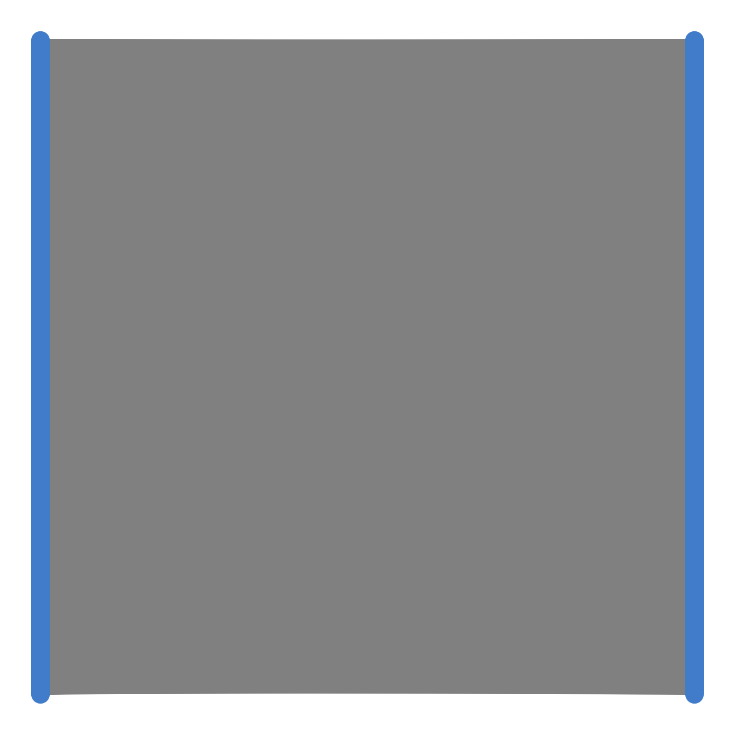

In [14]:
plt.figure(figsize=(10,10))
top = nx.bipartite.sets(G_bu)[0]
pos = nx.bipartite_layout(G_bu, top)
nx.draw(G_bu, pos=pos, with_labels=False, node_color=default_node_color, edge_color=default_edge_color)
plt.show()

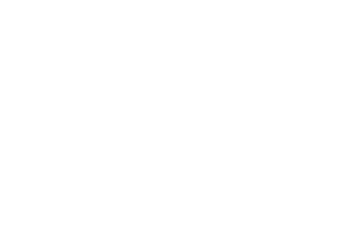

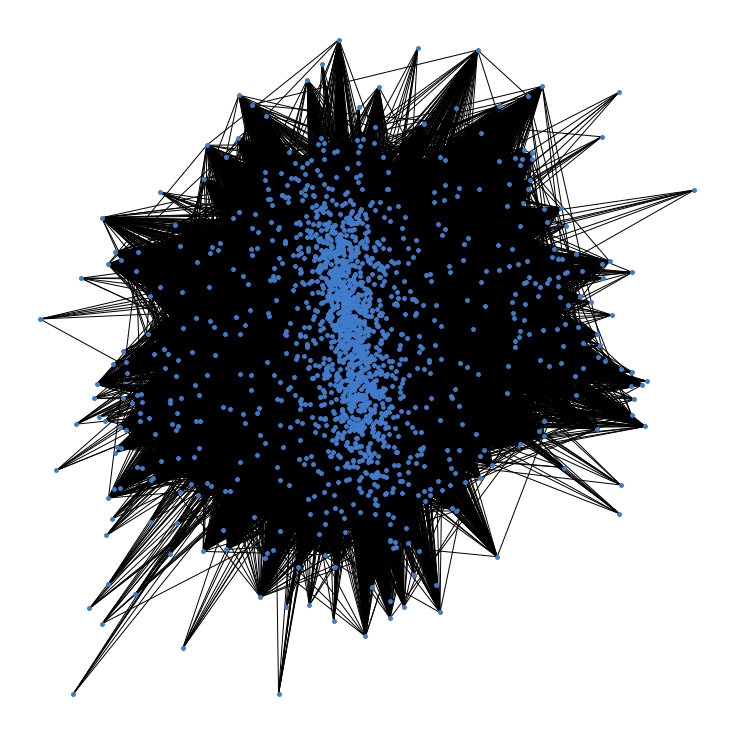

In [15]:
plt.axis("off")
plt.figure(figsize=(10,10))

nx.draw(G_bu, pos=nx.spring_layout(G_bu), node_color=default_node_color, 
                 edges_color=default_edge_color, with_labels=False, node_size=15)

**Tripartite** approach is an extension of bipartite, allows transactions to be represented as a vertex/node. On one hand, it increases network complexity, though on the other hand allows extra node embeddings for merchants and cardholders and every transaction. 

For this approach, a weighted tripartite graph $G=(V,E,\omega)$ where $V = V_t \cup V_c \cup V_m$ where each node *c* represents a customer, *m* represents a merchant and *t* is a transaction. Two edges $(v_c, v_t)$ and $(v_t, v_m)$ are created for each transaction, $v_t$ from customer $v_c$ to merchant $v_m$.

Finally for each edge, we assign a (positive) weight representing amount (in USD) of transaction. As a node is created for each transaction, there is no need to aggregate multiple transactions from a customer to merchant.

In [16]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()): # can make directed graph with nx.DiGraph
    df = df_input.copy()
    
    # mapping to assign a node_id to each merchant, customer and transaction
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])
    
    # use from_edgelist to build networkx graph
    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    # three node types, set attributes accordingly 
    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")
    
    # assign weight and label for each edge type,in nodes and out nodes
    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

In [17]:
G_tu = build_graph_tripartite(df, nx.Graph(name="Tripartite Undirect"))

In [18]:
G_td = build_graph_tripartite(df, nx.DiGraph(name="Tripartite Direct"))

In [19]:
from networkx.algorithms import bipartite
all([bipartite.is_bipartite(G) for G in [G_bu, G_tu]])

True

In [20]:
for G in [G_bu, G_tu]:
    print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1676
Number of edges: 201725
Average degree: 240.7220
Name: 
Type: Graph
Number of nodes: 267016
Number of edges: 530680
Average degree:   3.9749


Real transactions are represented as edges. For both bipartite and tripartite, the classification of fraudulent/genuine is described to be an edge classification task. So given an edge label (0 for genuine, 1 for fraudulent) describe whether transaction for an edge is fraudulent or genuine.

In tripartite, we have far more edges and nodes to account for all the transactions. Though the average degree of the bipartite is bigger than tripartite as expected, as the connections are split in the tripartite graph by presence of transaction nodes. 

### Network Topology Analysis and Community Detection

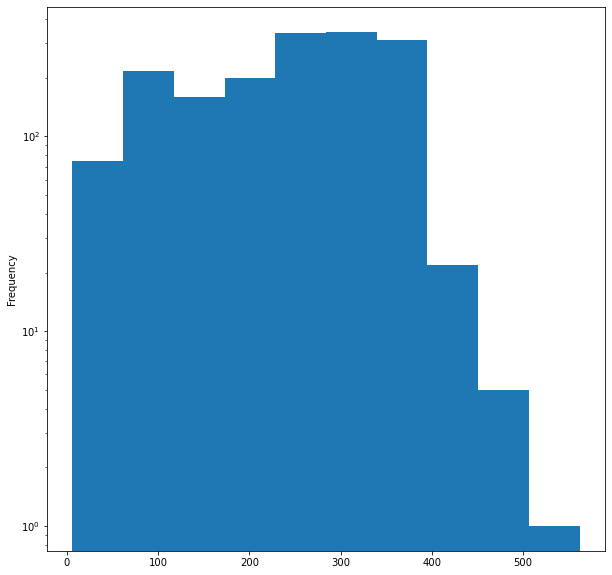

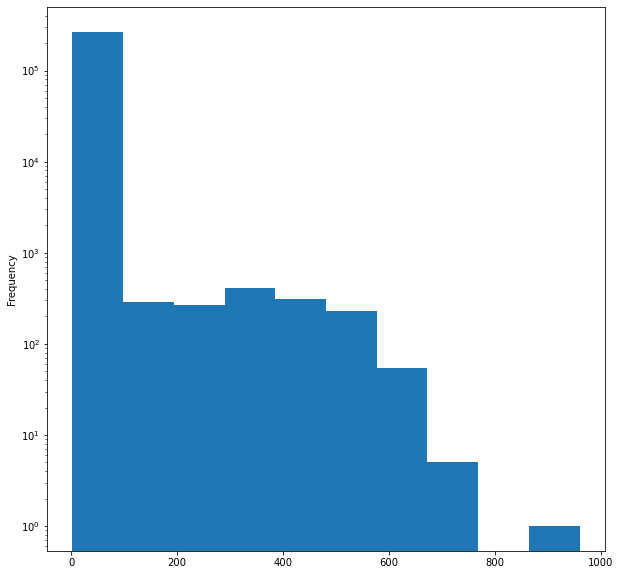

In [21]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10, 10))
    degrees = pd.Series({k: v for k, v in nx.degree(G)})
    degrees.plot.hist()
    plt.yscale("log")

See how node distribution reflects average degree we saw. Bipartite graph has more varied distribution, with peak around 300, but tripartite has big peak at degree 2, whileother part of tripartite distribution is similar to bipartite. These reflect the differences in how our graphs were defined. In tripartite, all connections pass through transaction nodes, these nodes are the majority in the graph and they all have degree of 2.

[  5.03   58.25   98.44  215.656]
[  4.21  48.51  76.4  147.1 ]


KeyboardInterrupt: 

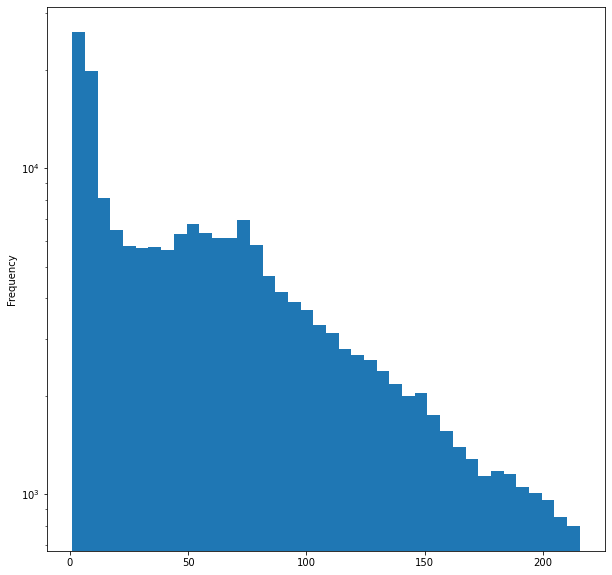

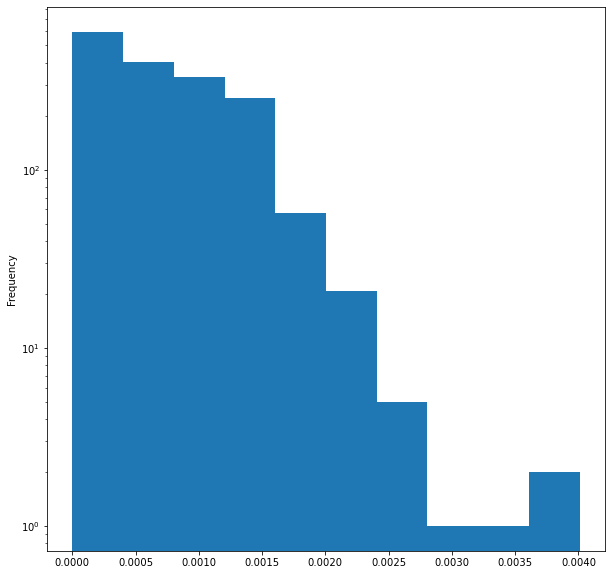

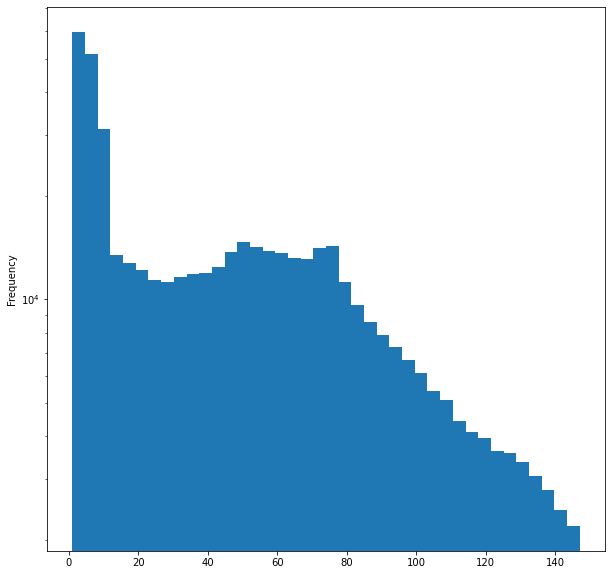

<Figure size 720x720 with 0 Axes>

In [24]:
# compute quantile distributions
for G in [G_bu, G_tu]:
    allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
    quant_dist = np.quantile(allEdgesWeights.values, [0.10, 0.5, 0.7, 0.9])
    print("Quantile Distribution:", quant_dist)
    allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                         if d[2]["weight"] < quant_dist[-1]})
    plt.figure(figsize=(10,10))
    allEdgesWeightsFiltered.plot.hist(bins=40)
    plt.yscale("log")
    
    # look at betweenness centrality
    plt.figure(figsize=(10,10))
    bC = nx.betweenness_centrality(G)
    bc_distr = pd.Series(bC)
    bc_distr.plot.hist()
    plt.yscale("log")
    
    # print assortativity
    print(nx.degree_pearson_correlation_coefficient(G))


Can see due to aggregation of transaction have sime merchant and customer, distribution of bipartite is shifted to the right compared to tripartite graphs whereedge weights were not computed, aggregating multiple transactions. 

Betweenness centrality for both is low, large number of non-bridging nodes inside the network. 

Both graphs have negative assortativity, likely showing that well-connected individuals associate with poor-connected individuals. For bipartite, the value is low (-0.15) since customers who have low degree are only connected with merchants who have high degrees due to the high number of incoming transactions. This is even lower (-0.81) for tripartite graph. This is expected due to presence of transaction nodes, as those nodes always have a degree of 2, and are linked to customers and merchants represented by highly connected nodes.

### Community Detection
Another analysis method is community detection, this can help to identify specific fraudulent patterns.

In [25]:
import community
for G in [G_bu, G_tu]:
    parts = community.best_partition(G, random_state=42, weight='weight')
    communities = pd.Series(parts)
    print(communities.value_counts().sort_values(ascending=False))

6     538
2     189
5     110
12    109
10    107
0     103
11    103
4     101
7     100
3      78
9      64
8      39
13     29
1       6
dtype: int64
11     4828
99     4493
26     4313
94     4115
8      4036
       ... 
47     1160
104    1132
95      954
85      845
103     561
Length: 106, dtype: int64


With the tripartite graph, we find 106 communities and only 12 for the bipartite. Better to plot distribution of nodes contained in different communities:

<AxesSubplot:ylabel='Frequency'>

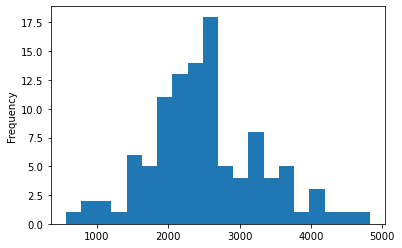

In [26]:
communities.value_counts().plot.hist(bins=20)

Peak is reached around 2,500. Means there are >30 large communities that have >2000 nodes. Possible to see that a few communitieshave fewer than 1000 nodes and more than 3000 nodes.

In each set of communities, we can calculate the % of fraudulent transactions; we here want to identify specific sub-graphs where there is a high concentration of fraudulent transactions.

In [27]:
graphs = []
d = {}
for x in communities.unique():
    # generate node-induced subraph using nodes contained in specific community
    tmp = nx.subgraph(G, communities[communities==x].index)
    
    # use graph to compute % of fraudulent transactions as ratio of number of fraudulent edges
    # over all edges in the graph
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)

6      6.857728
94     6.551151
8      5.966981
1      5.870918
89     5.760271
         ...   
103    0.889680
72     0.836013
85     0.708383
60     0.503461
46     0.205170
Length: 106, dtype: float64

<AxesSubplot:ylabel='Frequency'>

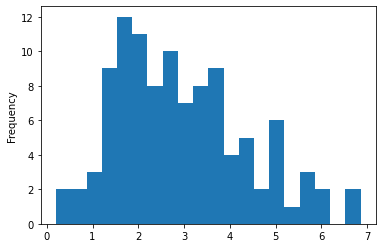

In [29]:
pd.Series(d).plot.hist(bins=20)

Large part of distribution is around communities with ratio between 2 and 4. There are a few communities with low ratio (<1) and high ratio (>5).

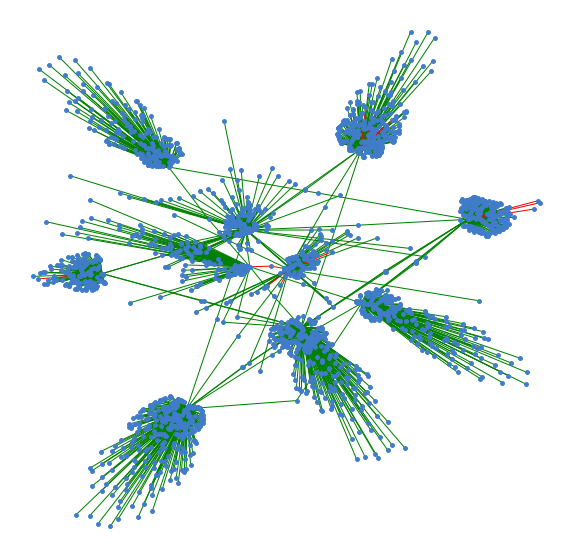

In [28]:
gId = 10
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

We can here see an interesting pattern that could be used to perform deeper exploration of some important graph sub-regions. Density of fraudulent is higher than regular transactions.

### Supervised Learning
We here can see how machine learning can be used to automatically detect fraudulent transactions, we want to classify each edge in correct class: fraudulent or genuine. We will describe our pipeline as:
- Sampling procedure for imbalanced task
- Use of unsupervised embedding alg to create feature vector for each edge
- Application of supervised and supervised ML algs to the feature space defined in the previous point

In [30]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

# subsample majority to mitigate class imbalance
df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])
print(df_downsampled.shape)

# build graph from earlier on with subsampled set
print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

(15012, 23)
1    7506
0    7506
Name: is_fraud, dtype: int64


In [31]:
from sklearn.model_selection import train_test_split

# standard train/test split to separate our dataset
train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [32]:
# add edges and nodes
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

In [33]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

# build feature space using Node2Vec
node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


In [34]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    
    # Edge2Vec alg, the previously computed node2vec is used to generate feature space
    embeddings_train = cl(keyed_vectors=model_train.wv) 
    
    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    # random forest trained on feature set from previous step
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 
    
    # display different performance metrics
    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.6470588235294118
Recall: 0.051816958277254375
F1-Score: 0.09595015576323988
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.7170963364993216
Recall: 0.7113055181695828
F1-Score: 0.7141891891891893
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.65
Recall: 0.026244952893674293
F1-Score: 0.05045278137128072
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.6811594202898551
Recall: 0.031628532974428
F1-Score: 0.06045016077170418


Tripartite has better precision but bipartite has better recall, so in this use case, a bipartite would be better choice since it achieves higher F1 withsmaller graph (in terms of nodes & edges) compared to tripartite.

-  Precision: TP/TP+FP (TP over all predicted positive, actual predicted results)
-  Recall: TP/TP+FN (TP over all actual positives).

So we want higher recall, to detect all actual positives.

### Unsupervised Learning 

In [35]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:50<00:00,  5.00s/it]


In [36]:
from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    
    # Edge2Vec, previously computed Node2Vec on train/val sets to generate feature space
    embedding_edge = cl(keyed_vectors=unsup_vals.wv) 
    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    
    # from sklearn to fit on feature set generated in previous set
    kmeans = KMeans(2, random_state=42).fit(embedding)
    
    # compute metrics
    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)
    
    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.0020709184095985224
Homogeneity: 0.0019921353908200507
Completeness: 0.0022732281677309966
V-Measure: 0.002123419597031632
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.0950035826869578
Homogeneity: 0.09146193416068593
Completeness: 0.09893108768049966
V-Measure: 0.0950500027824188
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.20089053799747766
Homogeneity: 0.20093818278312775
Completeness: 0.20092177247016946
V-Measure: 0.20092997729158366
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.16485785189726881
Homogeneity: 0.16418913982583944
Completeness: 0.16561552838151505
V-Measure: 0.16489924957439692


In unsupervised case, introduction of transaction nodes improves overall performance. 